In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from scipy.signal import stft, istft, get_window
from scipy.fftpack import fft, fftshift, fftfreq
from IPython.display import Audio
from tqdm import tnrange, tqdm_notebook, tqdm
from dlbeamformer_utilities import *
from dlbeamformers import *
from utilities import *
from IPython.display import Audio

random_seed = 0
# Make pretty figures
palette, cmap = config_figures()

VISUALIZE_BEAMPATTERNS = True

main_color = (79/255, 177/255, 200/255)
import matplotlib as mpl
mpl.style.use("seaborn-talk")

In [ ]:
59/255

In [7]:
datapath = "CMU_ARCTIC/cmu_us_bdl_arctic/wav"
train_data, test_data = load_data(datapath)

sampling_frequency, stft_params, sound_speed = parse_parameters()

signal_max_frequency = sampling_frequency / 2

# Array geometry
pos_x = np.array([-35.0, -35.0, 0.0, 35.0, 35.0, 0.0, 0.0]) * 1e-3
pos_y = np.array([20.0, -20.0, -40.0, -20.0, 20.0, 40.0, 0.0]) * 1e-3
n_mics = len(pos_x)
pos_z = np.zeros(n_mics)
array_geometry = np.row_stack((pos_x, pos_y, pos_z))

# Fix elevation angle
elevation = -90 # [degree]

# Source/Target/Look angles
elevation_s = np.array([elevation]) # [degree]
azimuth_s = np.array([180])
source_steering_vectors = compute_steering_vectors(array_geometry, 
        sampling_frequency=sampling_frequency, n_fft_bins=stft_params["n_fft_bins"], 
        elevation_grid=elevation_s, 
        azimuth_grid=azimuth_s)

# Scanning angles
scanning_elevation_grid = np.array([elevation]) # [degree]
scanning_azimuth_grid = np.arange(0, 360, 0.1) # [degree]
scanning_steering_vectors = compute_steering_vectors(array_geometry, 
        sampling_frequency=sampling_frequency, n_fft_bins=stft_params["n_fft_bins"], 
        elevation_grid=scanning_elevation_grid, 
        azimuth_grid=scanning_azimuth_grid)

In [8]:
np.random.seed(random_seed)
n_interferences = 1
input_sinrs_db = np.arange(-15, 16, 2)
input_inr_db = 20
input_inr = from_db(input_inr_db)
beamformer_list = ["DS", "MVDR", "MPDR", "DL-MVDR", "DL-MPDR"]
# beamformer_list = ["mvdr"]
beamformers = {}
tf_frames = []
for beamformer_name in beamformer_list:
    beamformers[beamformer_name] = {
        "weights": [None]*len(input_sinrs_db),
        "sinr_db": [None]*len(input_sinrs_db),
        "average_sinr_db": [],
        "out": [None]*len(input_sinrs_db),
        "ir_db": [None] * len(input_sinrs_db),
        "average_ir_db": [],
        "nr_db": [None] * len(input_sinrs_db),
        "average_nr_db": [],
        "sr_db": [None] * len(input_sinrs_db),
        "average_sr_db": []
    }
        
n_MC_iters = 1
for i_input_sinr in tqdm(range(len(input_sinrs_db)), desc="Input SINR"):
    input_sinr = from_db(input_sinrs_db[i_input_sinr])
    for beamformer_name in beamformer_list:
        beamformers[beamformer_name]["weights"][i_input_sinr] = []
        beamformers[beamformer_name]["sinr_db"][i_input_sinr] = []
        beamformers[beamformer_name]["out"][i_input_sinr] = []
        beamformers[beamformer_name]["ir_db"][i_input_sinr] = []
        beamformers[beamformer_name]["nr_db"][i_input_sinr] = []
        beamformers[beamformer_name]["sr_db"][i_input_sinr] = []
    for i_MC_iter in tqdm(range(n_MC_iters), desc="Monte Carlo iterations"):
    
        source = {
            "signal": test_data[np.random.choice(len(test_data))],
            "elevation": elevation_s,
            "azimuth": azimuth_s
        }
        
        interferences = []
        interference_signals = []
        for i_interference in range(n_interferences):
            random_azimuth_1 = np.random.uniform(scanning_azimuth_grid[0], azimuth_s - 30)[0]
            random_azimuth_2 = np.random.uniform(azimuth_s + 30, scanning_azimuth_grid[-1])[0]
            random_azimuth = np.random.choice(np.array([random_azimuth_1, random_azimuth_2]))
            interference_signal = test_data[np.random.choice(len(test_data))]
            interference = {
                "signal": interference_signal,
                "elevation": np.array([elevation]),
                "azimuth": np.array([np.random.uniform(
                    scanning_azimuth_grid[0], scanning_azimuth_grid[-1])])
#                 "azimuth": np.array([30])
#                 "azimuth": np.array([random_azimuth])
            }
            interferences.append(interference)
        
        received_stft_multichannel, source_stft_multichannel, \
        interference_stft_multichannel, noise_stft_multichannel \
            = simulate_multichannel_tf_mixtures(array_geometry, source,
                interferences, sampling_frequency, stft_params, input_inr, input_sinr)
        
        for beamformer_name in beamformer_list:        
            if beamformer_name.lower() == "ds":
                tf_frames_multichannel = None
            elif beamformer_name.lower() in ["mvdr", "dl-mvdr"]:
                tf_frames_multichannel = interference_stft_multichannel
            elif beamformer_name.lower() in ["mpdr", "dl-mpdr"]:
                tf_frames_multichannel = received_stft_multichannel

            if beamformer_name.lower() in ["dl-mvdr", "dl-mpdr"]:
                source_angle_index = 0
                tf_beamformer = dlbeamformer.choose_weights(source_angle_index,
                                    tf_frames_multichannel)
            else:
                tf_beamformer = compute_tf_beamformers(source_steering_vectors[:, 0, 0, :], 
                        beamformer_name=beamformer_name,
                        tf_frames_multichannel=tf_frames_multichannel,
                        diagonal_loading_param=5)

            # Compute beamformer output and SINR
            tf_out, out, _ = compute_tf_beamformer_output(tf_beamformer, 
                                received_stft_multichannel, sampling_frequency, 
                                stft_params)
            
            sinr_db, sinr  = compute_sinr(source_stft_multichannel, 
                interference_stft_multichannel+noise_stft_multichannel, tf_beamformer)

            # Compute interference output and interference reduction
            interference_tf_out, interference_out, _ = compute_tf_beamformer_output(tf_beamformer, 
                                interference_stft_multichannel, sampling_frequency, 
                                stft_params)
            
            interference_reduction = compute_power(interference_stft_multichannel[:, 0, :]) / compute_power(interference_tf_out)
            interference_reduction_db = to_db(interference_reduction)
            
            # Compute noise output and noise reduction
            noise_tf_out, noise_out, _ = compute_tf_beamformer_output(tf_beamformer, 
                                noise_stft_multichannel, sampling_frequency, 
                                stft_params)
            
            noise_reduction = compute_power(noise_stft_multichannel[:, 0, :]) / compute_power(noise_tf_out)
            noise_reduction_db = to_db(noise_reduction)
            
            # Compute source output and source distortion/reduction
            source_tf_out, source_out, _ = compute_tf_beamformer_output(tf_beamformer, 
                                source_stft_multichannel, sampling_frequency, 
                                stft_params)
            
            source_reduction = compute_power(source_stft_multichannel[:, 0, :]) / compute_power(source_tf_out)
            source_reduction_db = to_db(source_reduction)
            
            beamformers[beamformer_name]["weights"][i_input_sinr].append(tf_beamformer)
            beamformers[beamformer_name]["sinr_db"][i_input_sinr].append(sinr_db[0][0])
            beamformers[beamformer_name]["out"][i_input_sinr].append(out)
            beamformers[beamformer_name]["ir_db"][i_input_sinr].append(interference_reduction_db)
            beamformers[beamformer_name]["nr_db"][i_input_sinr].append(noise_reduction_db)
            beamformers[beamformer_name]["sr_db"][i_input_sinr].append(source_reduction_db)
    tf_frames.append((received_stft_multichannel, source_stft_multichannel, \
        interference_stft_multichannel, noise_stft_multichannel))
    for beamformer_name in beamformers.keys():
        beamformers[beamformer_name]["average_sinr_db"].append(
            to_db(np.mean(from_db(np.asarray(beamformers[beamformer_name]["sinr_db"][i_input_sinr])))))
        beamformers[beamformer_name]["average_ir_db"].append(
            to_db(np.mean(from_db(np.asarray(beamformers[beamformer_name]["ir_db"][i_input_sinr])))))
        beamformers[beamformer_name]["average_nr_db"].append(
            to_db(np.mean(from_db(np.asarray(beamformers[beamformer_name]["nr_db"][i_input_sinr])))))
        beamformers[beamformer_name]["average_sr_db"].append(
            to_db(np.mean(from_db(np.asarray(beamformers[beamformer_name]["sr_db"][i_input_sinr])))))

Input SINR: 100%|██████████| 16/16 [00:02<00:00,  7.45it/s]


In [ ]:
slide = "title_"
filename = "mixture"
filepath = os.path.join("figures", slide + filename + ".jpg")
received_stft_multichannel, source_stft_multichannel, \
        interference_stft_multichannel, noise_stft_multichannel = tf_frames[0]
t, source = convert_tf_frames_to_signal(source_stft_multichannel[:, 0, :], sampling_frequency, stft_params)
t, interference = convert_tf_frames_to_signal(interference_stft_multichannel[:, 0, :], sampling_frequency, stft_params)
t, noise = convert_tf_frames_to_signal(noise_stft_multichannel[:, 0, :], sampling_frequency, stft_params)
fig = plt.figure(figsize=(9, 6)); ax = fig.add_subplot(111);
ax.plot(t, source, color=main_color);
ax.plot(t, interference, color="gray", alpha=0.5);
ax.axis("off");
plt.tight_layout()
# plt.savefig(filepath, dpi=600)

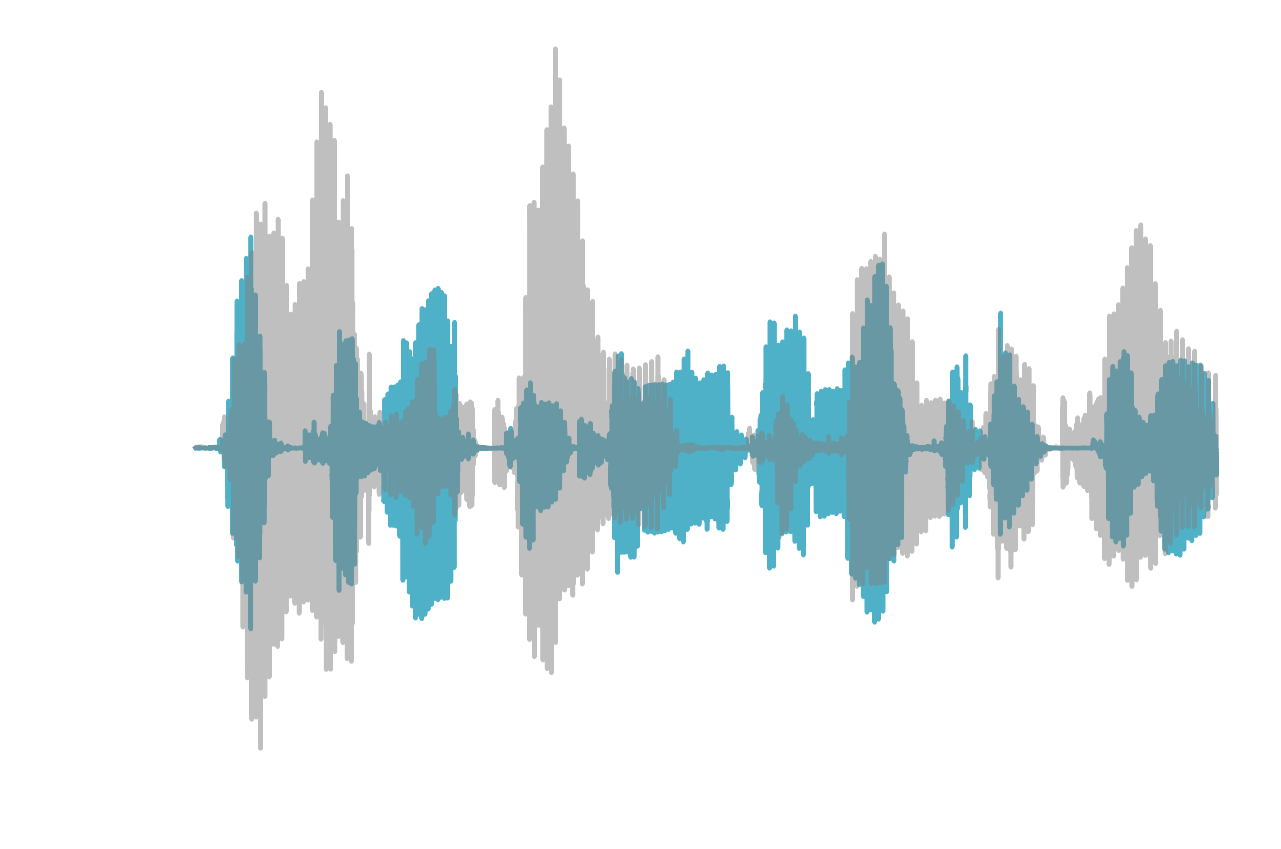

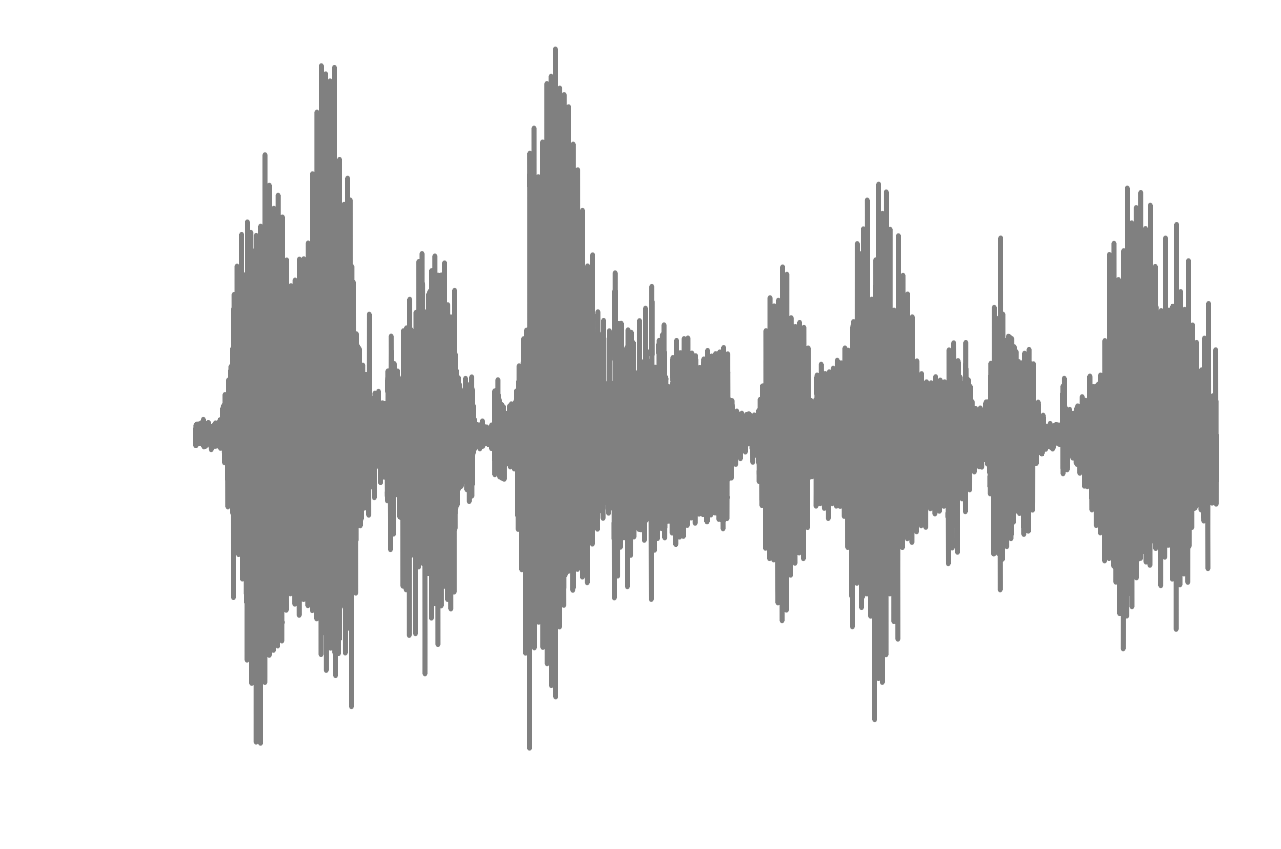

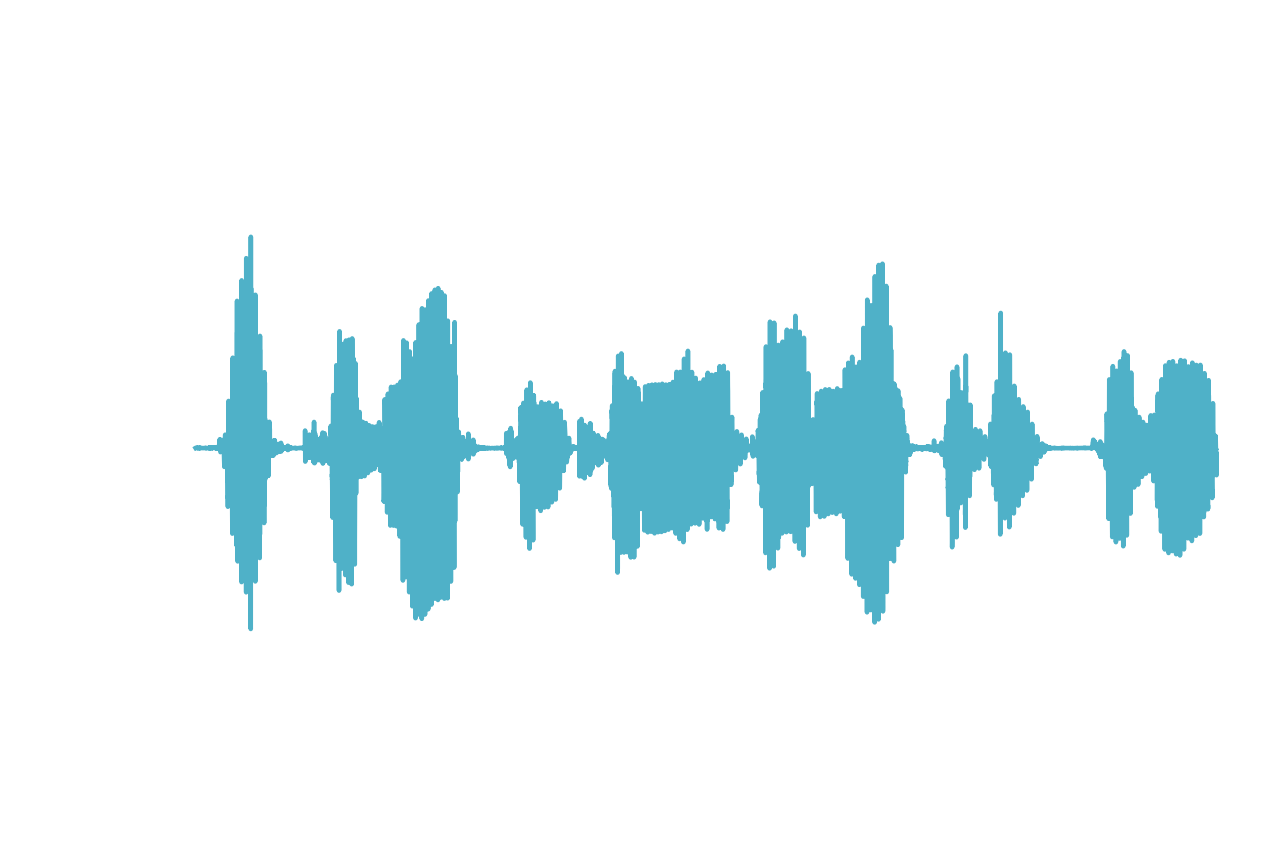

In [4]:
slide = "single_channel_model_"
filename = "individuals"
filepath = os.path.join("figures", slide + filename + ".jpg")
received_stft_multichannel, source_stft_multichannel, \
        interference_stft_multichannel, noise_stft_multichannel = tf_frames[6]
t, source = convert_tf_frames_to_signal(source_stft_multichannel[:, 0, :], sampling_frequency, stft_params)
t, interference = convert_tf_frames_to_signal(interference_stft_multichannel[:, 0, :], sampling_frequency, stft_params)
t, noise = convert_tf_frames_to_signal(noise_stft_multichannel[:, 0, :], sampling_frequency, stft_params)
fig = plt.figure(figsize=(9, 6)); ax = fig.add_subplot(111);
ax.plot(t, source, color=main_color);
ax.plot(t, interference, color="gray", alpha=0.5);
ax.axis("off");
plt.tight_layout()
plt.savefig(filepath, dpi=600)

filename = "mixture"
filepath = os.path.join("figures", slide + filename + ".jpg")
t, received = convert_tf_frames_to_signal(received_stft_multichannel[:, 0, :], sampling_frequency, stft_params)
fig = plt.figure(figsize=(9, 6)); ax = fig.add_subplot(111);
ax.plot(t, received, color="gray");
ax.axis("off");
plt.tight_layout()
plt.savefig(filepath, dpi=600)

filename = "source"
filepath = os.path.join("figures", slide + filename + ".jpg")
t, source = convert_tf_frames_to_signal(source_stft_multichannel[:, 0, :], sampling_frequency, stft_params)
fig = plt.figure(figsize=(9, 6)); ax = fig.add_subplot(111);
ax.plot(t, interference, color="white");
ax.plot(t, source, color=main_color);
ax.axis("off");
plt.tight_layout()
plt.savefig(filepath, dpi=600)

filename = "mixture_audio"
filepath = os.path.join("figures", slide + filename + ".wav")
write_audio_file(received, sampling_frequency, filepath)

filename = "source_audio"
filepath = os.path.join("figures", slide + filename + ".wav")
write_audio_file(source, sampling_frequency, filepath)

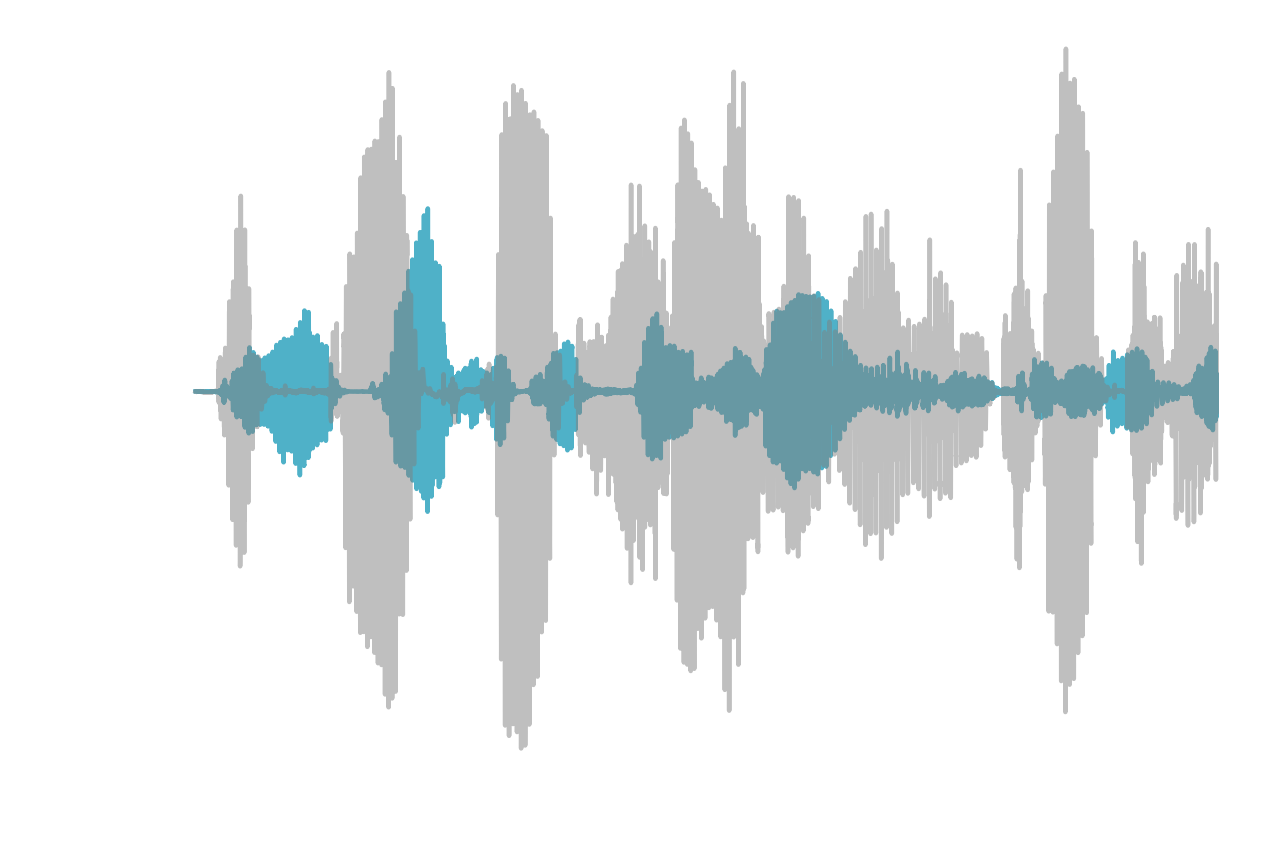

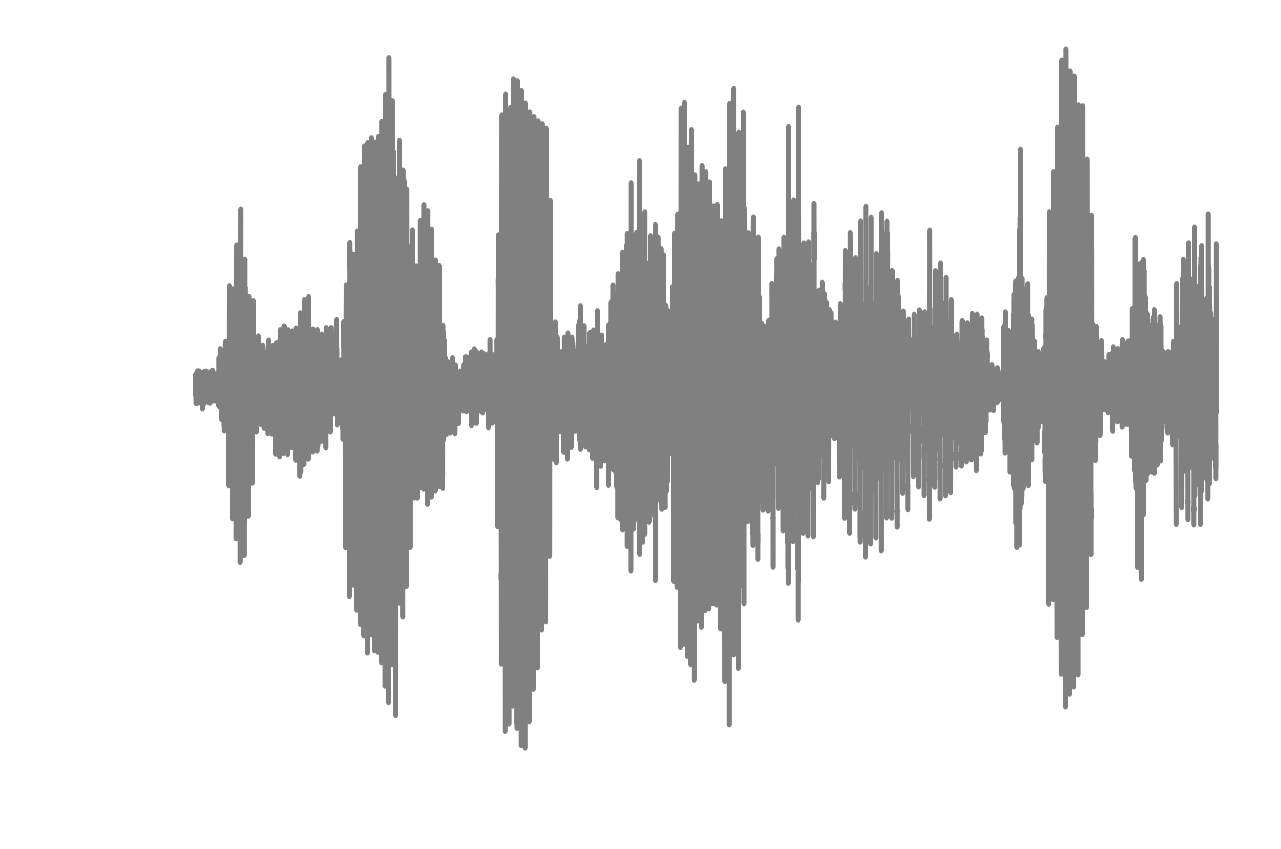

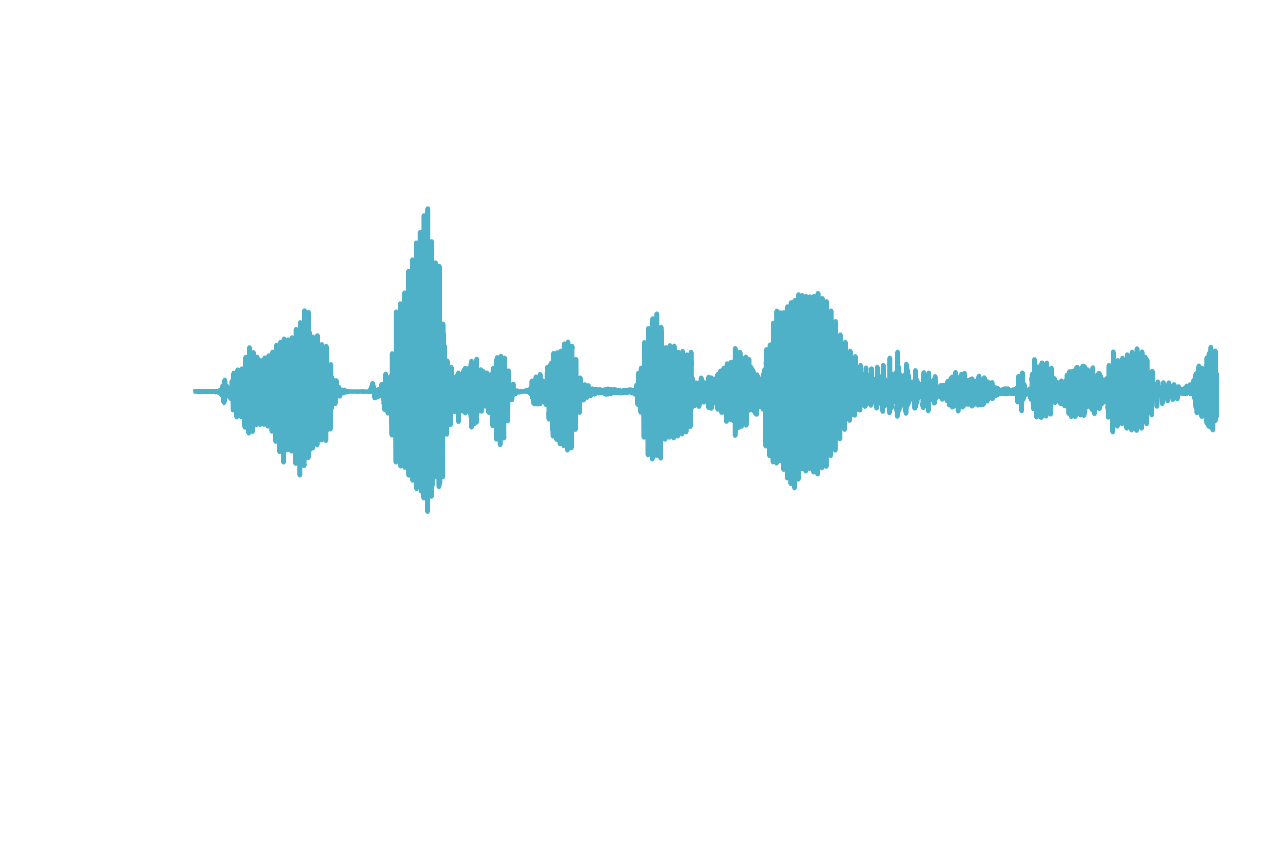

In [5]:
slide = "single_channel_model_large_interference_noise_"
filename = "individuals"
filepath = os.path.join("figures", slide + filename + ".jpg")
received_stft_multichannel, source_stft_multichannel, \
        interference_stft_multichannel, noise_stft_multichannel = tf_frames[2]
t, source = convert_tf_frames_to_signal(source_stft_multichannel[:, 0, :], sampling_frequency, stft_params)
t, interference = convert_tf_frames_to_signal(interference_stft_multichannel[:, 0, :], sampling_frequency, stft_params)
t, noise = convert_tf_frames_to_signal(noise_stft_multichannel[:, 0, :], sampling_frequency, stft_params)
fig = plt.figure(figsize=(9, 6)); ax = fig.add_subplot(111);
ax.plot(t, source, color=main_color);
ax.plot(t, interference, color="gray", alpha=0.5);
ax.axis("off");
plt.tight_layout()
plt.savefig(filepath, dpi=600)

filename = "mixture"
filepath = os.path.join("figures", slide + filename + ".jpg")
t, received = convert_tf_frames_to_signal(received_stft_multichannel[:, 0, :], sampling_frequency, stft_params)
fig = plt.figure(figsize=(9, 6)); ax = fig.add_subplot(111);
ax.plot(t, received, color="gray");
ax.axis("off");
plt.tight_layout()
plt.savefig(filepath, dpi=600)

filename = "source"
filepath = os.path.join("figures", slide + filename + ".jpg")
t, source = convert_tf_frames_to_signal(source_stft_multichannel[:, 0, :], sampling_frequency, stft_params)
fig = plt.figure(figsize=(9, 6)); ax = fig.add_subplot(111);
ax.plot(t, interference, color="white");
ax.plot(t, source, color=main_color);
ax.axis("off");
plt.tight_layout()
plt.savefig(filepath, dpi=600)

filename = "mixture_audio"
filepath = os.path.join("figures", slide + filename + ".wav")
write_audio_file(received, sampling_frequency, filepath)

filename = "source_audio"
filepath = os.path.join("figures", slide + filename + ".wav")
write_audio_file(source, sampling_frequency, filepath)

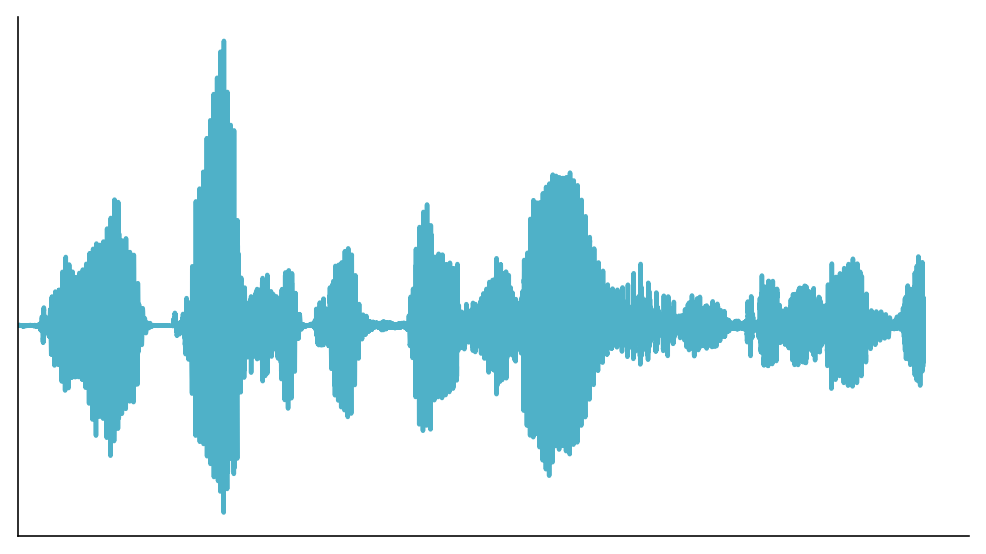

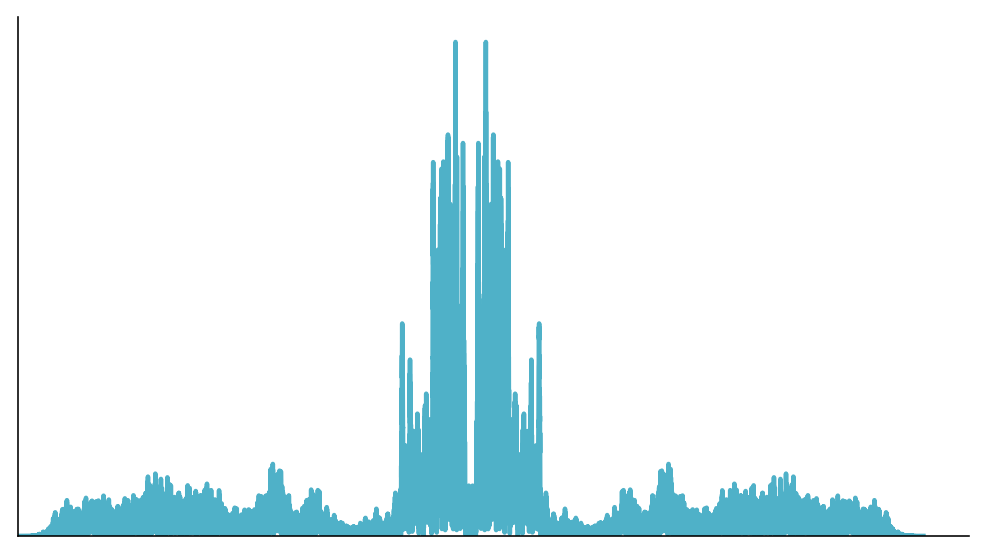

In [17]:
slide = "speech_wideband_"
import matplotlib as mpl
mpl.rcParams['axes.facecolor']: "red"
from scipy.fftpack import fft, fftshift, fftfreq

source_fft = fft(source)

filename = "signal"
filepath = os.path.join("figures", slide + filename + ".jpg")
fig = plt.figure(figsize=(7, 4)); ax0 = fig.add_subplot(111)
ax0.plot(source, color=main_color)
ax0.set_xticks([]); ax0.set_yticks([]);
ax0.set_xlim(0);
plt.tight_layout()
plt.savefig(filepath, dpi=600)

filename = "fft"
filepath = os.path.join("figures", slide + filename + ".jpg")
fig = plt.figure(figsize=(7, 4)); ax1 = fig.add_subplot(111)
ax1.plot(np.linspace(0, sampling_frequency/2, len(source_fft)), fftshift(np.abs(source_fft)), color=main_color)
ax1.set_xticks([]); ax1.set_yticks([]);
ax1.set_xlim(0); ax1.set_ylim(0);
plt.tight_layout()
plt.savefig(filepath, dpi=600)
# ax1.legend(["FFT"])
# ax1.set_ylim(-5, 55);

### Narrowband

In [27]:
def get_signal_Hz(Hz,sample_rate,length_ts_sec):
    ## 1 sec length time series with sampling rate 
    ts1sec = list(np.linspace(0,np.pi*2*Hz,sample_rate))
    ## 1 sec length time series with sampling rate 
    ts = ts1sec*length_ts_sec
    return(list(np.sin(ts)))

sample_rate   = sampling_frequency
length_ts_sec = 2
## --------------------------------- ##
## 3 seconds of "digit 1" sound
## Pressing digit 2 buttom generates 
## the sine waves at frequency 
## 697Hz and 1209Hz.
## --------------------------------- ##
ts1  = np.array(get_signal_Hz(697, sample_rate,length_ts_sec)) 
ts1 += np.array(get_signal_Hz(1209,sample_rate,length_ts_sec))
ts1  = list(ts1)

## -------------------- ##
## 2 seconds of silence
## -------------------- ##
ts_silence = [0]*sample_rate*1

## --------------------------------- ##
## 3 seconds of "digit 2" sounds 
## Pressing digit 2 buttom generates 
## the sine waves at frequency 
## 697Hz and 1336Hz.
## --------------------------------- ##
ts2  = np.array(get_signal_Hz(697, sample_rate,length_ts_sec)) 
ts2 += np.array(get_signal_Hz(1336,sample_rate,length_ts_sec))
ts2  = list(ts2)

## -------------------- ##
## Add up to 7 seconds
## ------------------- ##
tone = np.array(ts1 + ts_silence  + ts2)
low_tone = np.array(get_signal_Hz(200, sampling_frequency, 5))

In [28]:
display(Audio(low_tone, rate=sampling_frequency, autoplay=True))

In [26]:
len(ts_silence)

16000

In [53]:
np.random.seed(random_seed)
n_interferences = 1
input_sinrs_db = np.arange(-15, 16, 2)
input_inr_db = 50
input_inr = from_db(input_inr_db)
beamformer_list = ["DS", "MVDR", "MPDR", "DL-MVDR", "DL-MPDR"]
beamformer_list = ["DS", "MVDR", "MPDR"]
beamformers = {}
tf_frames = []
for beamformer_name in beamformer_list:
    beamformers[beamformer_name] = {
        "weights": [None]*len(input_sinrs_db),
        "sinr_db": [None]*len(input_sinrs_db),
        "average_sinr_db": [],
        "out": [None]*len(input_sinrs_db),
        "ir_db": [None] * len(input_sinrs_db),
        "average_ir_db": [],
        "nr_db": [None] * len(input_sinrs_db),
        "average_nr_db": [],
        "sr_db": [None] * len(input_sinrs_db),
        "average_sr_db": []
    }
        
n_MC_iters = 1
for i_input_sinr in tqdm(range(len(input_sinrs_db)), desc="Input SINR"):
    input_sinr = from_db(input_sinrs_db[i_input_sinr])
    for beamformer_name in beamformer_list:
        beamformers[beamformer_name]["weights"][i_input_sinr] = []
        beamformers[beamformer_name]["sinr_db"][i_input_sinr] = []
        beamformers[beamformer_name]["out"][i_input_sinr] = []
        beamformers[beamformer_name]["ir_db"][i_input_sinr] = []
        beamformers[beamformer_name]["nr_db"][i_input_sinr] = []
        beamformers[beamformer_name]["sr_db"][i_input_sinr] = []
    for i_MC_iter in tqdm(range(n_MC_iters), desc="Monte Carlo iterations"):
    
        source = {
            "signal": tone,
            "elevation": elevation_s,
            "azimuth": azimuth_s
        }
        
        interferences = []
        interference_signals = []
        for i_interference in range(n_interferences):
            random_azimuth_1 = np.random.uniform(scanning_azimuth_grid[0], azimuth_s - 30)[0]
            random_azimuth_2 = np.random.uniform(azimuth_s + 30, scanning_azimuth_grid[-1])[0]
            random_azimuth = np.random.choice(np.array([random_azimuth_1, random_azimuth_2]))
            interference_signal = low_tone
            interference = {
                "signal": interference_signal,
                "elevation": np.array([elevation]),
#                 "azimuth": np.array([np.random.uniform(
#                     scanning_azimuth_grid[0], scanning_azimuth_grid[-1])])
                "azimuth": np.array([30])
#                 "azimuth": np.array([random_azimuth])
            }
            interferences.append(interference)
        
        received_stft_multichannel, source_stft_multichannel, \
        interference_stft_multichannel, noise_stft_multichannel \
            = simulate_multichannel_tf_mixtures(array_geometry, source,
                interferences, sampling_frequency, stft_params, input_inr, input_sinr)
        
        for beamformer_name in beamformer_list:        
            if beamformer_name.lower() == "ds":
                tf_frames_multichannel = None
            elif beamformer_name.lower() in ["mvdr", "dl-mvdr"]:
                tf_frames_multichannel = interference_stft_multichannel
            elif beamformer_name.lower() in ["mpdr", "dl-mpdr"]:
                tf_frames_multichannel = received_stft_multichannel

            if beamformer_name.lower() in ["dl-mvdr", "dl-mpdr"]:
                source_angle_index = 0
                tf_beamformer = dlbeamformer.choose_weights(source_angle_index,
                                    tf_frames_multichannel)
            else:
                tf_beamformer = compute_tf_beamformers(source_steering_vectors[:, 0, 0, :], 
                        beamformer_name=beamformer_name,
                        tf_frames_multichannel=tf_frames_multichannel,
                        diagonal_loading_param=5)

            # Compute beamformer output and SINR
            tf_out, out, _ = compute_tf_beamformer_output(tf_beamformer, 
                                received_stft_multichannel, sampling_frequency, 
                                stft_params)
            
            sinr_db, sinr  = compute_sinr(source_stft_multichannel, 
                interference_stft_multichannel+noise_stft_multichannel, tf_beamformer)

            # Compute interference output and interference reduction
            interference_tf_out, interference_out, _ = compute_tf_beamformer_output(tf_beamformer, 
                                interference_stft_multichannel, sampling_frequency, 
                                stft_params)
            
            interference_reduction = compute_power(interference_stft_multichannel[:, 0, :]) / compute_power(interference_tf_out)
            interference_reduction_db = to_db(interference_reduction)
            
            # Compute noise output and noise reduction
            noise_tf_out, noise_out, _ = compute_tf_beamformer_output(tf_beamformer, 
                                noise_stft_multichannel, sampling_frequency, 
                                stft_params)
            
            noise_reduction = compute_power(noise_stft_multichannel[:, 0, :]) / compute_power(noise_tf_out)
            noise_reduction_db = to_db(noise_reduction)
            
            # Compute source output and source distortion/reduction
            source_tf_out, source_out, _ = compute_tf_beamformer_output(tf_beamformer, 
                                source_stft_multichannel, sampling_frequency, 
                                stft_params)
            
            source_reduction = compute_power(source_stft_multichannel[:, 0, :]) / compute_power(source_tf_out)
            source_reduction_db = to_db(source_reduction)
            
            beamformers[beamformer_name]["weights"][i_input_sinr].append(tf_beamformer)
            beamformers[beamformer_name]["sinr_db"][i_input_sinr].append(sinr_db[0][0])
            beamformers[beamformer_name]["out"][i_input_sinr].append(out)
            beamformers[beamformer_name]["ir_db"][i_input_sinr].append(interference_reduction_db)
            beamformers[beamformer_name]["nr_db"][i_input_sinr].append(noise_reduction_db)
            beamformers[beamformer_name]["sr_db"][i_input_sinr].append(source_reduction_db)
    tf_frames.append((received_stft_multichannel, source_stft_multichannel, \
        interference_stft_multichannel, noise_stft_multichannel))
    for beamformer_name in beamformers.keys():
        beamformers[beamformer_name]["average_sinr_db"].append(
            to_db(np.mean(from_db(np.asarray(beamformers[beamformer_name]["sinr_db"][i_input_sinr])))))
        beamformers[beamformer_name]["average_ir_db"].append(
            to_db(np.mean(from_db(np.asarray(beamformers[beamformer_name]["ir_db"][i_input_sinr])))))
        beamformers[beamformer_name]["average_nr_db"].append(
            to_db(np.mean(from_db(np.asarray(beamformers[beamformer_name]["nr_db"][i_input_sinr])))))
        beamformers[beamformer_name]["average_sr_db"].append(
            to_db(np.mean(from_db(np.asarray(beamformers[beamformer_name]["sr_db"][i_input_sinr])))))

Input SINR: 100%|██████████| 16/16 [00:05<00:00,  2.79it/s]


In [61]:
play_tf_frames(received_stft_multichannel[:, 0, :], sampling_frequency, stft_params)

In [51]:
beamformer_name = "DS"
beamformers[beamformer_name]["out"][7][0]
display(Audio(beamformers[beamformer_name]["out"][7][0], rate=sampling_frequency, autoplay=True))

In [58]:
beamformer_name = "MVDR"
beamformers[beamformer_name]["out"][8][0]
display(Audio(beamformers[beamformer_name]["out"][8][0], rate=sampling_frequency, autoplay=True))

In [55]:
input_sinrs_db[8]


1